In [10]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from IPython.display import display, display_markdown

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import seaborn as sns
import subprocess as sp
import matplotlib.pyplot as plt
from collections import Counter
from os import path

import logging
logging.getLogger().setLevel(logging.WARNING)

def display_md(md, **kwargs):
    return display_markdown(md, raw=True, **kwargs)

def convert_notebook(title, output='html'):
    convert = sp.run(f'jupyter nbconvert {title}.ipynb --to {output} --output {title}.{output}'.split(' '))
    if convert.returncode == 0:
        display_md(f'Jupyter notebook `{title}` converted successfully.')
    else:
        display_md(f'Error: encountered problem converting Jupyter notebook `{title}`')

sns.set(style='whitegrid')

# Experiment 4
In Experiment 4, we modify an implementation of word2vec (the most widely used word embedding model) so that we can probe the internal state (the embeddings) during training. By computing the embedding projections for our color/adjective pairs during training, we can identify the sentences that are most influential in shaping the relationship between color and adjective.

We compute this by, for each training sample the model sees, taking the distance between the embedding projection in the _current_ state of the model and in the embedding projection in the _final_ state of the model, and correcting this for the previous state of the model and the current learning rate.  
This provides a normalized measure of how much the training sample moved the embedding projection relative to its final state.

In [17]:
tsv_prefix = '../probe_data/'

tsvs = [
    'light_heavy.tsv',
    'relaxed_tense.tsv',
    'alive_dead.tsv',
    'exciting_dull.tsv',
    'soft_hard.tsv',
    'fast_slow.tsv',
    'calm_angry.tsv',
    'ripe_unripe.tsv',
    'fresh_stale.tsv',
    'submissive_aggressive.tsv',
    'active_passive.tsv',
    'selfless_jealous.tsv',
    'cold_hot.tsv',
    'clean_dirty.tsv',
    'like_dislike.tsv',
    'new_old.tsv',
    'happy_sad.tsv',
]

colors = ['red', 'black', 'orange', 'yellow', 'brown', 'green', 'purple', 'white', 'blue']

In [18]:
# read sentences from training corpus
df_sentences = pd.read_csv('../corpora/dedup.all_fic.clean.txt',
                           header=None, na_filter=False, skip_blank_lines=False)

# set index for sentences and rename column
df_sentences['idx'] = range(len(df_sentences))
df_sentences = df_sentences.rename(columns={0: 'text'})
display(df_sentences)

,text,idx
0,p Your grandmother Mr,0
1,So I keep look ing,1
2,Keller took a slip of name and address to memo...,2
3,Invasive procedure or invasive personality The...,3
4,Sitting there at the keyboard he hunched forwa...,4
...,...,...
7260420,Two doors down the hall was her office,7260420
7260421,I mean after all if I m talking to someone who...,7260421
7260422,Responding to the growls a herd of grazing HAD...,7260422
7260423,O Connell OK,7260423


In [25]:
dfs = []

# loop over dimension tsvs
for q, tsv in enumerate(tsvs):
    print(f'processing dataframe {q + 1} of {len(tsvs)}')
    
    # read embedding projection data
    df = pd.read_csv(path.join(tsv_prefix, tsv), sep='\t')
    print('read dataframe')
    
    # split dimension
    dim_a, dim_b = tsv[:-4].split('_')
    
    # select only final epoch (embedding space has stabilized somewhat, more informative data)
    df = df[df['epoch'] == 4]
    
    # merge sentences into embedding projection dataframe
    df = df.merge(df_sentences, how='left', left_on='sentence', right_on='idx')
    print('merged dataframe')
    
    # store reference value for each color (projection at final time point)
    references = {color: df.loc[len(df) - 1, color] for color in colors}
    
    for color, ref in references.items():
        # compute distance to reference value (final time point) for each color
        df[color + '_dist'] = np.abs(df[color] - ref)
    
    for color in colors:
        # compute the percentage difference between distance at training sample n and training sample n - 1
        df[color + '_diff'] = df[color + '_dist'].pct_change().abs()
        
    # compute mean change across all colors
    #coldiff = [color + '_diff' for color in colors]
    #df['mean_diff'] = df[coldiff].abs().mean(axis=1)    

    for color in colors:
        # compute change for each color relative to the mean for all colors
        #df[color + '_diff_rel'] = df[color + '_diff']# / df['mean_diff']

        # correct relative change for model learning rate at time point of training sample
        #df[color + '_diff_corr'] = df[color + '_diff_rel'] / df['alpha']
        df[color + '_diff_corr'] = df[color + '_diff'] / df['alpha']
        
    print('computed corrected relative change')

    # get nameability data
    df_names = pd.read_csv('../color-semantics/data/mean_nameability.tsv', sep='\t')
    
    for color in colors:
        # sort sentences by corrected relative difference
        df_sort = df.replace([np.inf, -np.inf], np.nan).dropna().sort_values(color + '_diff_corr', ascending=False)
        for dimension in [dim_a, dim_b]:    
            names = df_names.loc[(df_names['color'] == color) & (df_names['dimension'] == dimension), 'modal_names'].values[0].split(',')
            #print(f'\nparticipant labels for {color} and {dimension}:')
            #print('\n'.join(names))
            scores = []
            count = 0
            count_all = 0
            for i, line in enumerate(df_sort['text'].values):
                if set(names) & set(line.split()):
                    count += 1
                    count_all += 1
                #if i % 100000 == 0:
                if i % round(len(df_sort) / 100) == 0:
                    scores.append([color, dimension, i / round(len(df_sort) / 100), count])
                    count = 0
                        
            if count_all == 0:
                count_all = 1
            df_temp = pd.DataFrame(scores, columns=['color', 'dimension', 'rank_bin', 'mediator_count'])
            df_temp['overall_count'] = count_all
            df_temp['relative_count'] = df_temp['mediator_count'] / count_all
            dfs.append(df_temp)

df_counts = pd.concat(dfs)
display(df_counts)

processing dataframe 1 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 2 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 3 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 4 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 5 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 6 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 7 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 8 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 9 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 10 of 17
read dataframe
merged dataframe
computed corrected relative change
processing dataframe 11 of 17
read data

,color,dimension,rank_bin,mediator_count,overall_count,relative_count
0,red,light,0.0,1,97993,0.000010
1,red,light,1.0,58372,97993,0.595675
2,red,light,2.0,3409,97993,0.034788
3,red,light,3.0,311,97993,0.003174
4,red,light,4.0,379,97993,0.003868
...,...,...,...,...,...,...
96,blue,sad,96.0,85,7589,0.011200
97,blue,sad,97.0,78,7589,0.010278
98,blue,sad,98.0,82,7589,0.010805
99,blue,sad,99.0,70,7589,0.009224


In [26]:
df_counts.to_csv('data/mediator_counts.tsv', sep='\t', index=False)

In [27]:
df_counts = pd.read_csv('data/mediator_counts.tsv', sep='\t')
display(df_counts)

,color,dimension,rank_bin,mediator_count,overall_count,relative_count
0,red,light,0.0,1,97993,0.000010
1,red,light,1.0,58372,97993,0.595675
2,red,light,2.0,3409,97993,0.034788
3,red,light,3.0,311,97993,0.003174
4,red,light,4.0,379,97993,0.003868
...,...,...,...,...,...,...
30775,blue,sad,96.0,85,7589,0.011200
30776,blue,sad,97.0,78,7589,0.010278
30777,blue,sad,98.0,82,7589,0.010805
30778,blue,sad,99.0,70,7589,0.009224


In [23]:
df_counts[df_counts['mediator_count'] == 1]
df_counts_filtered = df_counts[df_counts['mediator_count'] != 1]

In [6]:
df_counts_filtered = df_counts_filtered[df_counts_filtered['rank_bin'] != 0]
display(df_counts_filtered)

,color,dimension,rank_bin,mediator_count,overall_count,relative_count
1,red,light,1.0,30386,97993,0.310083
2,red,light,2.0,333,97993,0.003398
3,red,light,3.0,373,97993,0.003806
4,red,light,4.0,338,97993,0.003449
5,red,light,5.0,387,97993,0.003949
...,...,...,...,...,...,...
30775,blue,sad,96.0,83,7589,0.010937
30776,blue,sad,97.0,76,7589,0.010014
30777,blue,sad,98.0,80,7589,0.010542
30778,blue,sad,99.0,65,7589,0.008565


## Plotting the relative prevalence of salient label words in the most informative training sentences (by percentile)
We've compute the impact of each training sentence on each color/adjective pair's embedding projection, but before visualizing those data we're binning them by percentile. We can then count which percentage of salient labels (from the total number in the corpus) occurs in each percentile of informativeness.

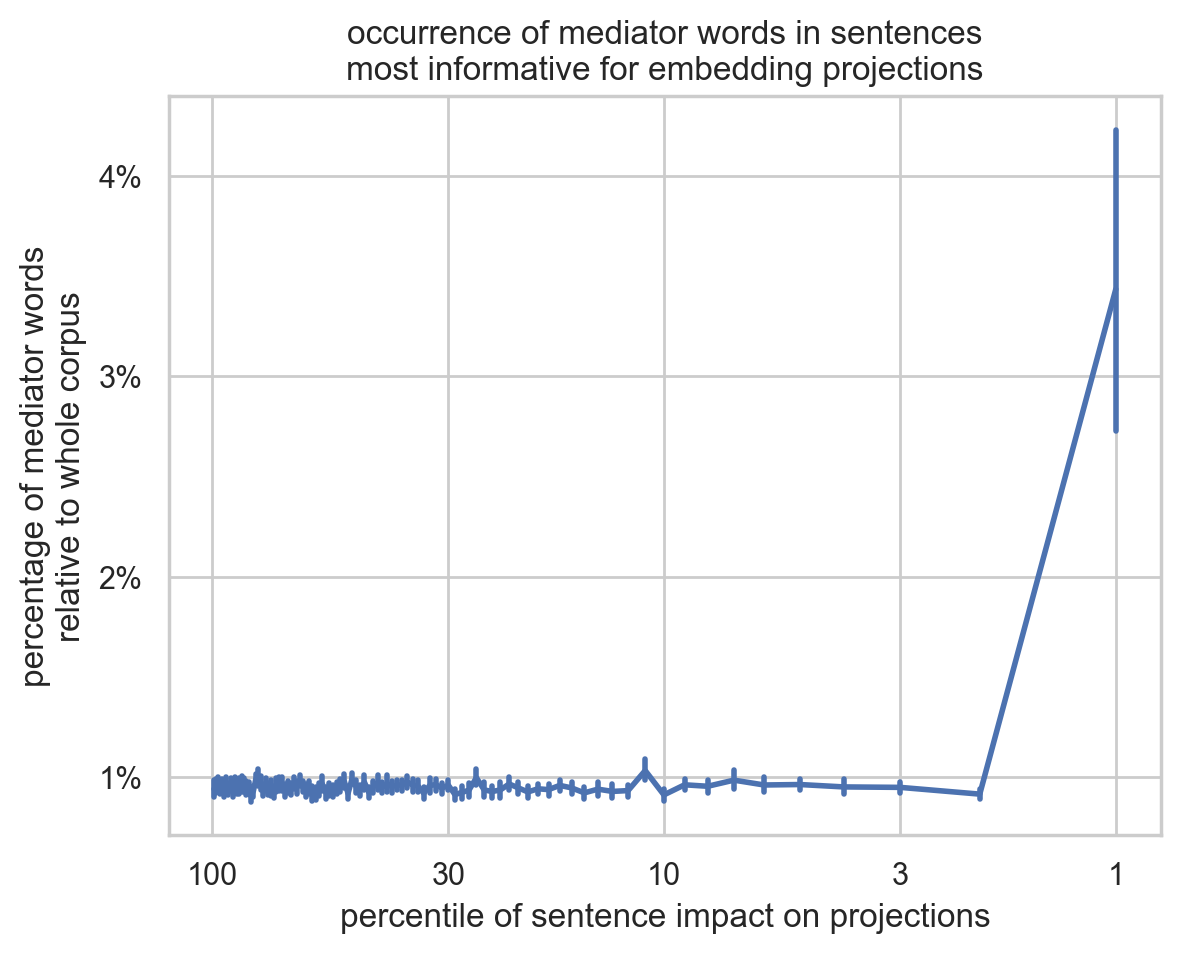

In [15]:
sns.set_style('whitegrid')
df_counts_mean = df_counts_filtered.groupby(['color', 'dimension','rank_bin']).mean().reset_index()
df_counts_mean['informative_pct'] = df_counts_mean['relative_count'] * 100

ax = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] < 100],
    x='rank_bin',
    y='informative_pct',
    err_style='bars',
    errorbar=('ci', 95),
    err_kws={'elinewidth': 2},
    lw=2,
)
ax.set(
    ylabel='percentage of mediator words\nrelative to whole corpus',
    xlabel='percentile of sentence impact on projections',
    title='occurrence of mediator words in sentences\nmost informative for embedding projections',
    yticks=[1, 2, 3, 4],
    yticklabels=['1%', '2%', '3%', '4%'],
    xscale='log',
    xticks=[1, 3, 10, 30, 100],
    xticklabels=[1, 3, 10, 30, 100],
)
ax.invert_xaxis()
ax.grid(True)
plt.savefig('figures/mediator_prevalence_by_colordim.pdf')

## Training sample informativeness, split by color, dimension, and color/dimension

/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/homebrew/lib/python3.9/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


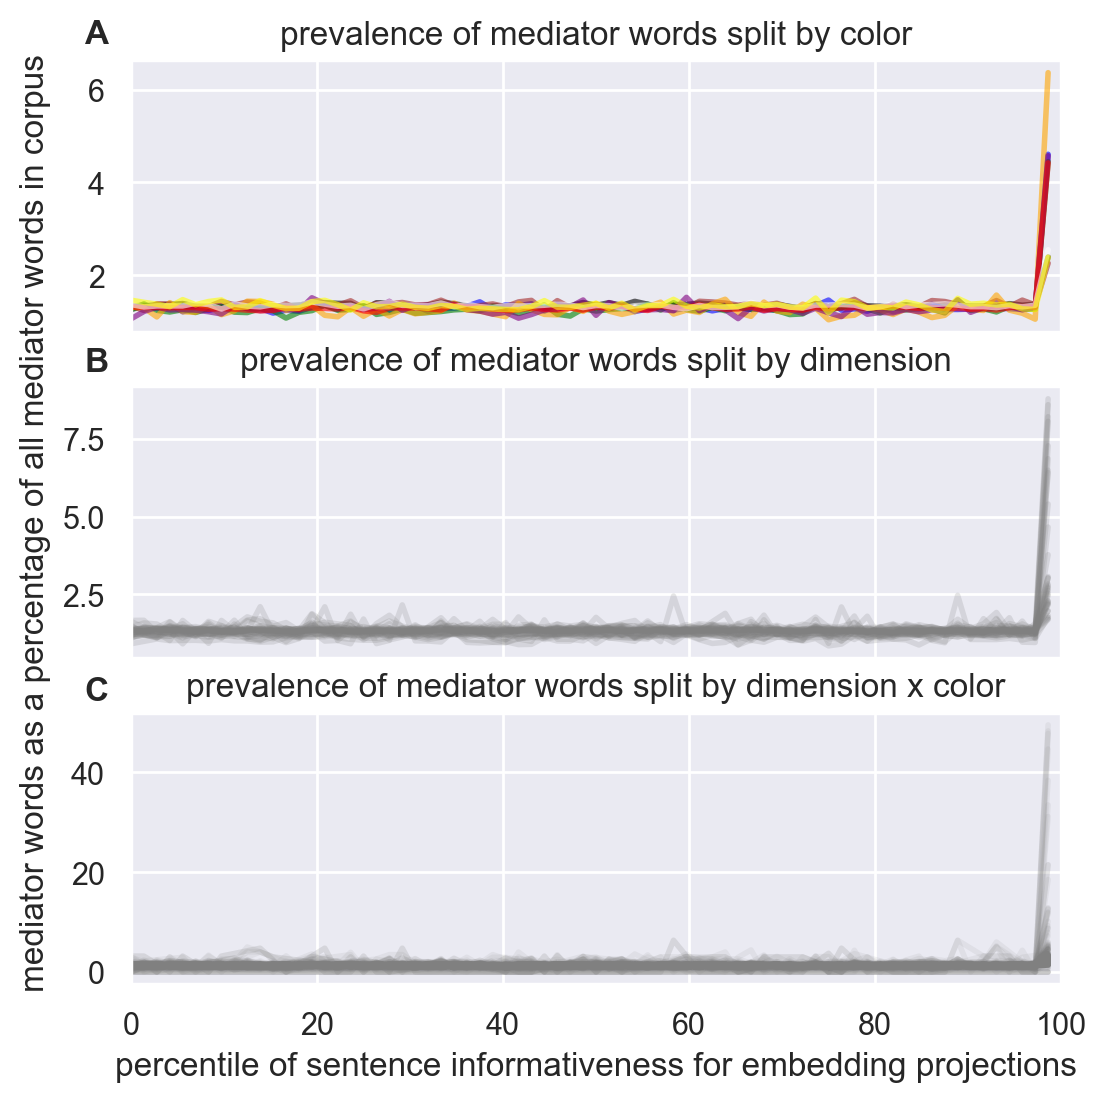

In [82]:
sns.set_style('darkgrid')

fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(3, 1, 1)

df_counts_mean = df_counts_filtered.groupby(['color', 'rank_bin']).mean().reset_index()
df_counts_mean['log_relative_count'] = np.log10(df_counts_mean['relative_count'])
df_counts_mean['rel_count_pct'] = df_counts_mean['relative_count'] * 100
df_counts_mean['log_rank'] = np.log10(df_counts_mean['rank_bin'])
df_counts_mean['rank_pct'] = 100 - (df_counts_mean['rank_bin'] / df_counts_mean['rank_bin'].max()) * 100

palette = {color: color for color in df_counts_mean['color'].unique()}

ax1 = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] != 0],
    hue='color',
    x='rank_pct',
    y='rel_count_pct',
    alpha=.6,
    lw=2,
    palette=palette,
)
ax1.set(
    ylabel='',
    #ylabel='percentage of all\nmediator words in corpus',
    xlabel='',
    title='prevalence of mediator words split by color',
    xticklabels='',
    xlim=[0, 100],
    #yticklabels=['0%', '1%', '2%', '3%', '4%', '5%', '6%'],
)
ax1.get_legend().remove()
ax1.text(-5, df_counts_mean['rel_count_pct'].max() * 1.1, 'A', weight='bold')


ax2 = fig.add_subplot(3, 1, 2)
df_counts_mean = df_counts_filtered.groupby(['dimension', 'rank_bin']).mean().reset_index()
df_counts_mean['log_relative_count'] = np.log10(df_counts_mean['relative_count'])
df_counts_mean['rel_count_pct'] = df_counts_mean['relative_count'] * 100
df_counts_mean['log_rank'] = np.log10(df_counts_mean['rank_bin'])
df_counts_mean['rank_pct'] = 100 - (df_counts_mean['rank_bin'] / df_counts_mean['rank_bin'].max()) * 100

ax2 = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] != 0],
    hue='dimension',
    x='rank_pct',
    y='rel_count_pct',
    alpha=.2,
    lw=2,
    palette=['gray'] * len(df_counts_mean['dimension'].unique()),
)
ax2.set(
    ylabel='mediator words as a percentage of all mediator words in corpus',
    xlabel='',
    title='prevalence of mediator words split by dimension',
    xticklabels='',
    xlim=[0, 100],
    #yticklabels=['0%', '1%', '2%', '3%', '4%', '5%', '6%'],
)
ax2.get_legend().remove()
ax2.text(-5, df_counts_mean['rel_count_pct'].max() * 1.1, 'B', weight='bold')


ax3 = fig.add_subplot(3, 1, 3)
df_counts_mean = df_counts_filtered.groupby(['color', 'dimension', 'rank_bin']).mean().reset_index()
df_counts_mean['log_relative_count'] = np.log10(df_counts_mean['relative_count'])
df_counts_mean['rel_count_pct'] = df_counts_mean['relative_count'] * 100
df_counts_mean['log_rank'] = np.log10(df_counts_mean['rank_bin'])
df_counts_mean['rank_pct'] = 100 - (df_counts_mean['rank_bin'] / df_counts_mean['rank_bin'].max()) * 100
df_counts_mean['colordim'] = df_counts_mean['color'] + '-' + df_counts_mean['dimension']

ax3 = sns.lineplot(
    data=df_counts_mean[df_counts_mean['rank_bin'] != 0],
    hue='colordim',
    x='rank_pct',
    y='rel_count_pct',
    alpha=.1,
    lw=2,
    palette=['gray'] * len(df_counts_mean['colordim'].unique()),
)
ax3.set(
    ylabel='',
    #ylabel='percentage of all\nmediator words in corpus',
    xlabel='percentile of sentence informativeness for embedding projections',
    title='prevalence of mediator words split by dimension x color',
    xlim=[0, 100],
    #yticklabels=['0%', '1%', '2%', '3%', '4%', '5%', '6%'],
)
ax3.get_legend().remove()
ax3.text(-5, df_counts_mean['rel_count_pct'].max() * 1.1, 'C', weight='bold')
plt.savefig('figures/mediator_prevalence_all.pdf')

# A little bit of data exploration for a few color/adjective pairings

## Which sentences are "most informative" for the happy/green relationship?

In [39]:
for i, line in enumerate(list(df_sort['text'][0:10])):
    print(f'\n{i}. {line}')


0. Residual sleep deprivation brain jitter

1. It feels wonderful to have the dog in his sights to pull the string back to his ear

2. The white sand path would be here she suddenly decides a thin strip from the dark tree to the back porch interrupted by a silent fountain

3. As the two females continue to talk Vernita reaches her hand inside the cereal box

4. The stained glass lamb of God above the altar looked dim and gloomy

5. p January 1989

6. Every man has his limit and that was mine

7. The manager is significantly younger than the waiter probably not much older than I am and he s wearing a spotty unconvincing beard and a white shirt so thin it s see through

8. Despite the Earth assigned nickname for his species that meant Kevin was looking at a quadrocular land octopus with green fur Imagine choosing to have only the most insubstantial of radio links to one s fellows interest to many back home

9. What would it mean disappeared like the ghosts of my Wisconsin birthplace In 

## Which sentences have neither color nor dimension words?

In [40]:
lines = df_sort['text']
j = 0
for i, line in enumerate(lines):
    if not ({color, 'happy', 'sad'} & set(line.split())):
        print(f'\n{i}. {line}')
        j += 1
    if j == 10:
        break


0. Residual sleep deprivation brain jitter

1. It feels wonderful to have the dog in his sights to pull the string back to his ear

2. The white sand path would be here she suddenly decides a thin strip from the dark tree to the back porch interrupted by a silent fountain

3. As the two females continue to talk Vernita reaches her hand inside the cereal box

4. The stained glass lamb of God above the altar looked dim and gloomy

5. p January 1989

6. Every man has his limit and that was mine

7. The manager is significantly younger than the waiter probably not much older than I am and he s wearing a spotty unconvincing beard and a white shirt so thin it s see through

9. What would it mean disappeared like the ghosts of my Wisconsin birthplace In a deep and vital way Nasiqrugvik would vanish into a monotonous undifferentiated terrain

10. Richter thingy


## What words do the "most informative" sentences have in common?

In [41]:
# count words in top 1000 sentences
top_words = ' '.join(df_sort['text'][0:1000]).split()
counter = Counter(top_words)
counts = counter.most_common()
top_df = pd.DataFrame(counts, columns=['word', 'top_count'])

# count words in whole corpus
all_words = ' '.join(df_sort['text']).split()
counter = Counter(all_words)
counts = counter.most_common()
all_df = pd.DataFrame(counts, columns=['word', 'all_count'])

# merge and correct top sentence word frequency for whole corpus word frequency
all_df = all_df.merge(top_df, how='left', on='word')

In [42]:
all_df['log_all_count'] = np.log(all_df['all_count'] / len(all_words))
all_df['log_top_count'] = np.log(all_df['top_count'] / len(top_words))
all_df['log_ratio'] = all_df['log_all_count'] / all_df['log_top_count']

diffs = all_df[all_df['top_count'] > 10].dropna()  # works okay, but arbitrary
#diffs = all_df[all_df['all_count'] > 10000].dropna()  # works okay, too, but still arbitrary
display(diffs.sort_values('log_ratio', ascending=False).head(25))

,word,all_count,top_count,log_all_count,log_top_count,log_ratio
607,happy,3402,97.0,-8.739198,-5.130021,1.703540
1329,sad,1471,39.0,-9.577619,-6.041170,1.585391
464,green,4512,64.0,-8.456821,-5.545849,1.524892
231,white,10423,17.0,-7.619546,-6.871518,1.108859
183,very,13360,20.0,-7.371296,-6.708999,1.098718
331,red,6994,11.0,-8.018508,-7.306836,1.097398
151,make,16744,23.0,-7.145521,-6.569237,1.087725
227,How,10605,15.0,-7.602236,-6.996681,1.086549
261,table,8818,12.0,-7.786766,-7.219825,1.078526
189,does,12847,17.0,-7.410451,-6.871518,1.078430


## Do the participant labels for unripe/green occur in the "most informative sentences"?

In [44]:
lines = df_sort['text']
j = 0
for i, line in enumerate(lines):
    if set(names) & set(line.split()):
        print(f'\n{i}. {line}')
        j += 1
    if j == 10:
        break


5793. When this is over he thought b u t th en found him self w ondering if the Rev took over w ould he go get C arolien a frog T he only carving not on a shelf was th e largest a big bellied jade frog w earing a gold crown

7592. A sad frog lay pinned prone

8364. Brown who It popped out like a frog

8428. 1016131 The old pond ah A frog Jumps in The water s sound

16888. The frog was cool to the touch and a fine bright shade of green

17330. The one that turned me from a handsome human prince into a small green frog answered Edward

17884. p After a week my tongue is dry my bowels are full of sand my legs twitch like a frog s

27587. But most of importance greatest news for Brody Bridge is Rostov method interfacing direct from mirror neuron frog leaping visual cortex optical receptor whole sensory shebang get it You play again Great story for league Great story for sponsor In three year all stadium using new Rostov system and you big star player again Brody gave Jack a wry smile

334

relative frequency of labels in first 10000 sentences versus the rest: 2.42


## Which sentences are "most informative" for the ripe/red relationship?

In [46]:
# set the color and dimension (adjective) we are interested in
dimension = 'sad'
color = 'blue'

In [47]:
# sort sentences by corrected relative difference
df_sort = df.replace([np.inf, -np.inf], np.nan).dropna().sort_values(color + '_diff_corr', ascending=False)

In [48]:
for i, line in enumerate(list(df_sort['text'][0:10])):
    print(f'\n{i}. {line}')


0. Hubb had been called into her residence to do some tinkering but never did he see the blind Negro only heard him moving around in a far bedroom

1. She drank again then cradled the empty cup between her hands as if cherishing the memory of it

2. Erectus he had said surely the evidence of those elephant hunts in Spain

3. I was always longing for my mother to hum because I had read somewhere that only happy people hummed

4. He grew hypersensitive to insults slights fishy glances he found himself looking for chances to vent righteous indignation

5. p Whose familiar voice is this p We ve just heard a conversation with lieutenant colonel Eitan Nachshon Lieutenant colonel Eitan Nachshon thank you says the broadcaster and the driver says again to the girl p My wife does n t want to leave me

6. At the moment it was clinging to the fin of the tail section with its small blue feet and it seemed to be staring directly at her as if it had flown up to investigate this unexpected incursion


## Which sentences have neither color nor dimension words?

In [49]:
lines = df_sort['text']
j = 0
for i, line in enumerate(lines):
    if not ({color, 'happy', 'sad'} & set(line.split())):
        print(f'\n{i}. {line}')
        j += 1
    if j == 10:
        break


0. Hubb had been called into her residence to do some tinkering but never did he see the blind Negro only heard him moving around in a far bedroom

1. She drank again then cradled the empty cup between her hands as if cherishing the memory of it

2. Erectus he had said surely the evidence of those elephant hunts in Spain

4. He grew hypersensitive to insults slights fishy glances he found himself looking for chances to vent righteous indignation

5. p Whose familiar voice is this p We ve just heard a conversation with lieutenant colonel Eitan Nachshon Lieutenant colonel Eitan Nachshon thank you says the broadcaster and the driver says again to the girl p My wife does n t want to leave me

7. Eventually the cool morning burned away and the air grew warm

8. When we got back to our hotel room the adults were still out

9. She stood at the table collecting potato skins for the pigs

10. Old Sharm is going to get his cut of that good life too

11. Richter thingy


## What words do the "most informative" sentences have in common?

In [50]:
# count words in top 1000 sentences
top_words = ' '.join(df_sort['text'][0:1000]).split()
counter = Counter(top_words)
counts = counter.most_common()
top_df = pd.DataFrame(counts, columns=['word', 'top_count'])

# count words in whole corpus
all_words = ' '.join(df_sort['text']).split()
counter = Counter(all_words)
counts = counter.most_common()
all_df = pd.DataFrame(counts, columns=['word', 'all_count'])

# merge and correct top sentence word frequency for whole corpus word frequency
all_df = all_df.merge(top_df, how='left', on='word')

In [51]:
all_df['log_all_count'] = np.log(all_df['all_count'] / len(all_words))
all_df['log_top_count'] = np.log(all_df['top_count'] / len(top_words))
all_df['log_ratio'] = all_df['log_all_count'] / all_df['log_top_count']

diffs = all_df[all_df['top_count'] > 10].dropna()  # works okay, but arbitrary
#diffs = all_df[all_df['all_count'] > 10000].dropna()  # works okay, too, but still arbitrary
display(diffs.sort_values('log_ratio', ascending=False).head(25))

,word,all_count,top_count,log_all_count,log_top_count,log_ratio
607,happy,3402,74.0,-8.739198,-5.428338,1.609922
1329,sad,1471,40.0,-9.577619,-6.043523,1.584774
349,blue,6299,90.0,-8.123170,-5.232593,1.552418
496,cut,4283,12.0,-8.508907,-7.247496,1.174048
521,sky,4062,11.0,-8.561886,-7.334507,1.167343
231,white,10423,19.0,-7.619546,-6.787964,1.122508
369,real,5931,11.0,-8.183368,-7.334507,1.115735
208,against,11837,18.0,-7.492331,-6.842031,1.095045
241,black,10023,15.0,-7.658679,-7.024352,1.090304
209,voice,11714,16.0,-7.502776,-6.959814,1.078014


## Do the participant labels for ripe/red occur in the "most informative sentences"?

In [52]:
df_names = pd.read_csv('../color-semantics/data/mean_nameability.tsv', sep='\t')
names = df_names.loc[(df_names['color'] == color) & (df_names['dimension'] == dimension), 'modal_names'].values[0].split(',')
print('participant color-dimension labels:\n')
print('\n'.join(names))

participant color-dimension labels:

tear
mood


In [53]:
lines = df_sort['text']
j = 0
for i, line in enumerate(lines):
    if set(names) & set(line.split()):
        print(f'\n{i}. {line}')
        j += 1
    if j == 10:
        break


189. A single adult sized tear snaked down from under her lashless blue veined eyelid landed in the delicate furred cup of her tiny ear

345. And how as wayfarer he has gone All for his lady try to start as any other bard might then slowly shape the mood of my audience to my own needs

3592. p It would I thought probably tear out the wardroom door when Kristine s mass fetched up against its knot at that velocity

3794. Instead of reinforcing her bleak mood it made her feel happy to be safe and cozy with her family all together again

4019. Maggie what can I say to make you believe me To make you stay He was remarkably attractive with the restaurant s dim mood lighting casting shadows across his rugged features

4443. With each step I climbed the feeling turned into a gnawing in my stomach gripped me a bit more pulling at my good mood

5157. Internally I shed a self pitying tear or two as I contemplated my sad lot

7061. The cold sun stings my bare tear swollen face

7388. My daughter 

In [56]:
count_10000 = 0
count_all = 0
for i, line in enumerate(lines):
    if set(names) & set(line.split()):
        if i < 10000:
            count_10000 += 1
        else:
            count_all += 1

rel_freq = (count_10000 / 10000) / (count_all / (i - 10000))
print(f'relative frequency of labels in first 10000 sentences versus the rest: {rel_freq:.2f}')

relative frequency of labels in first 10000 sentences versus the rest: 1.37


# Convert notebook to html

In [13]:
convert_notebook('experiment_4')

Jupyter notebook `experiment_4` converted successfully.